In [4]:
import numpy as np
from src.helper import get_split_data

In [5]:
X_trn, y_trn, X_val, y_val, X_tst, y_tst = get_split_data.split_data_for_training()

In [6]:
def calc_gini(df, val_col, label_col, pos_val, split_point, debug=False):
    """
    This function calculates the Gini impurity of a dataset. Gini impurity
    is a measure of the probability of a random sample being classified
    incorrectly when a feature is used to split the data. The lower the
    impurity, the better the split.
    Parameters:
    df (pd.DataFrame): The dataframe containing the data
    val_col (str): The column name of the feature used to split the data
    label_col (str): The column name of the target variable
    pos_val (str or int): The value of the target variable that represents
    the positive class
    split_point (float): The threshold used to split the data.
    debug (bool): optional, when set to True, prints the calculated Gini
    impurities and the final weighted average
    Returns:
    float: The weighted average of Gini impurity for the positive and
    negative subsets.
    """

    ge_split = df[val_col] >= split_point
    eq_pos = df[label_col] == pos_val
    tp = df[ge_split & eq_pos].shape[0]
    fp = df[ge_split & ~eq_pos].shape[0]
    tn = df[~ge_split & ~eq_pos].shape[0]
    fn = df[~ge_split & eq_pos].shape[0]
    pos_size = tp + fp
    neg_size = tn + fn
    total_size = len(df)
    if pos_size == 0:
        gini_pos = 0
    else:
       gini_pos = 1 - (tp / pos_size) ** 2 - (fp / pos_size) ** 2
    if neg_size == 0:
        gini_neg = 0
    else:
        gini_neg = 1 - (tn / neg_size) ** 2 - (fn / neg_size) ** 2
    weighted_avg = gini_pos * (pos_size / total_size) + \
                   gini_neg * (neg_size / total_size)
    if debug:
        print(f'{gini_pos=:.3} {gini_neg=:.3} {weighted_avg=:.3}')

    return weighted_avg


In [7]:
calc_gini(X_trn.assign(result_match=y_trn), val_col='points_difference', label_col='result_match', pos_val=1, split_point=0, debug=True)

gini_pos=0.492 gini_neg=0.447 weighted_avg=0.471


0.47063791917320763

Text(0.5, 0, 'Split Point')

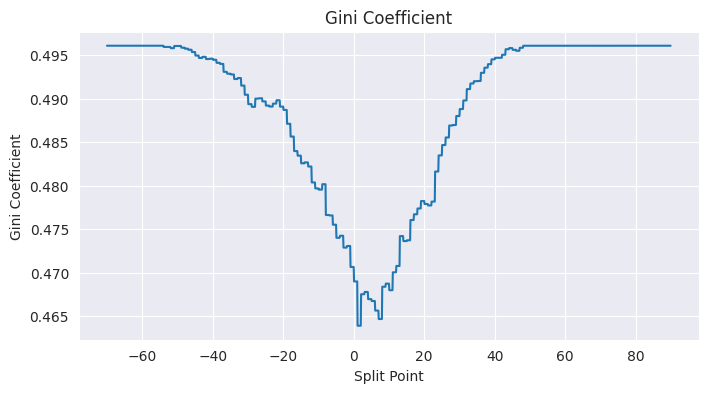

In [8]:
import matplotlib.pyplot as plt

values = np.arange(-70, 90, .1)
ginis = []
for v in values:
        ginis.append(calc_gini(X_trn.assign(result_match=y_trn), val_col='points_difference', label_col='result_match', pos_val=1, split_point=v, debug=False))
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(values, ginis)
ax.set_title('Gini Coefficient')
ax.set_ylabel('Gini Coefficient')
ax.set_xlabel('Split Point')

In [9]:
import pandas as pd

gini_df = pd.DataFrame({'gini': ginis, 'value': values})
print(gini_df.query('gini <= gini.min()'))

         gini  value
711  0.463887    1.1
712  0.463887    1.2
713  0.463887    1.3
714  0.463887    1.4
715  0.463887    1.5
716  0.463887    1.6
717  0.463887    1.7
718  0.463887    1.8
719  0.463887    1.9
720  0.463887    2.0


In [10]:
from sklearn import tree
import dtreeviz

stump_dt = tree.DecisionTreeClassifier(max_depth=1)
stump_dt.fit(X_trn, y_trn)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'points_difference <= 1.5\ngini = 0.496\nsamples = 2954\nvalue = [1608.0, 1346.0]\nclass = home_not_win'),
 Text(0.25, 0.25, 'gini = 0.455\nsamples = 1739\nvalue = [1131, 608]\nclass = home_not_win'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.477\nsamples = 1215\nvalue = [477, 738]\nclass = home_win'),
 Text(0.625, 0.5, '  False')]

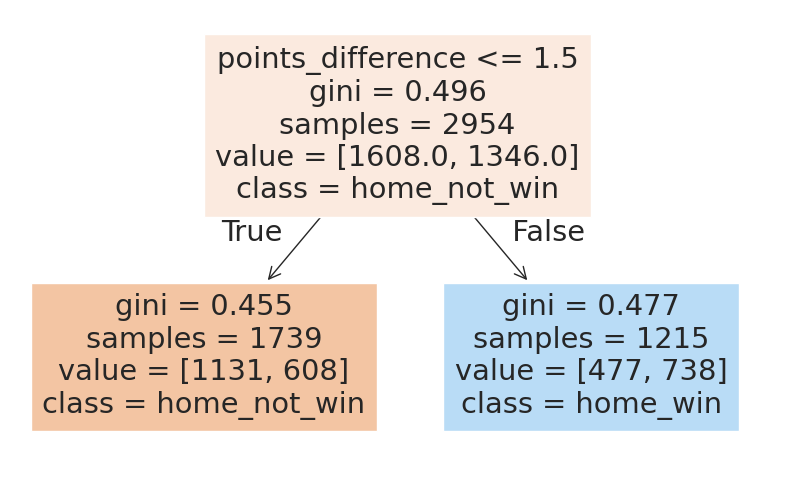

In [27]:
class_names_str = ['home_win' if cls == 1 else 'home_not_win' for cls in stump_dt.classes_]

fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_trn.columns)
tree.plot_tree(stump_dt, feature_names=features, filled=True, class_names=class_names_str, ax=ax)

In [12]:
stump_dt.score(X_val, y_val)

0.6

In [13]:
from sklearn import dummy
dummy_model = dummy.DummyClassifier()
dummy_model.fit(X_trn, y_trn)
dummy_model.score(X_val, y_val)

0.6

In [14]:
import xgboost as xgb
kag_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
kag_stump.fit(X_trn, y_trn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
kag_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
kag_stump.fit(X_trn, y_trn)
kag_stump.score(X_val, y_val)

0.6

In [24]:
from src.helper.plot_tree import my_dot_export

my_dot_export(kag_stump, num_trees=0, filename='img/stump_xg_kag.dot', title='XGBoost Stump')

In [ ]:
import numpy as np
def inv_logit(p: float) -> float:
    """
    Compute the inverse logit function of a given value.
    The inverse logit function is defined as:
    f(p) = exp(p) / (1 + exp(p))
    Parameters
    ----------
    p : float
    The input value to the inverse logit function.
    Returns
    -------
    float
    The output of the inverse logit function.
    """
    return np.exp(p) / (1 + np.exp(p))

In [25]:
inv_logit(-0.012807931)

np.float64(0.4967980610212124)

In [26]:
inv_logit(.182794467)

np.float64(0.5455717933963169)